# BIND Paper Analysis: Power Spectrum Analysis

This notebook analyzes the matter power spectrum $P(k)$ for BIND-generated fields compared to hydrodynamic simulations and the hydro-replacement baseline.

## Contents
1. [Setup & Imports](#1-setup--imports)
2. [Power Spectrum Computation Functions](#2-power-spectrum-computation)
3. [CV Dataset Analysis](#3-cv-dataset-analysis)
4. [1P Dataset Analysis](#4-1p-dataset-analysis)
5. [SB35 Dataset Analysis](#5-sb35-dataset-analysis)
6. [Parameter Correlation Analysis](#6-parameter-correlation-analysis)

---

## Key Quantity: Power Spectrum Suppression $S(k)$

We define the power spectrum suppression as:

$$S(k) = \frac{P_{\rm method}(k)}{P_{\rm DMO}(k)}$$

where $P_{\rm method}$ is the power spectrum from hydro, BIND, or hydro-replace fields.

---

## 1. Setup & Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import glob
from scipy.stats import spearmanr

# Power spectrum library

import Pk_library as PKL

# Local utilities
import sys
sys.path.insert(0, '..')
from paper_notebooks.paper_utils import (
    setup_plotting_style, BOX_SIZE, GRID_SIZE, MODEL_NAME,
    load_1p_params, load_sb35_metadata,
    savefig_paper, PARAM_LATEX_NAMES
)

setup_plotting_style()

import os
os.makedirs('paper_plots', exist_ok=True)

## 2. Power Spectrum Computation Functions

In [2]:
def compute_power(full_hydro, full_dm, full_hydro_replace):
    """
    Compute power spectra for hydro, DMO, and hydro-replace fields.
    
    Returns
    -------
    tuple : (k, Pk_hydro, Pk_dmo, Pk_replace, Nmodes)
    """
    # Compute overdensity fields
    delta_hydro = full_hydro / np.mean(full_hydro, dtype=np.float64) - 1.0
    delta_dmo = full_dm / np.mean(full_dm, dtype=np.float64) - 1.0
    delta_replace = full_hydro_replace / np.mean(full_hydro_replace, dtype=np.float64) - 1.0
    
    # Compute 2D power spectra
    Pk2D_replace = PKL.Pk_plane(delta_replace.astype(np.float32), BOX_SIZE, 'CIC', threads=0)
    Pk2D_hydro = PKL.Pk_plane(delta_hydro.astype(np.float32), BOX_SIZE, 'CIC', threads=0)
    Pk2D_dmo = PKL.Pk_plane(delta_dmo.astype(np.float32), BOX_SIZE, 'CIC', threads=0)
    
    return Pk2D_hydro.k, Pk2D_hydro.Pk, Pk2D_dmo.Pk, Pk2D_replace.Pk, Pk2D_hydro.Nmodes


def compute_binded_power(binded_maps):
    """
    Compute power spectra for BIND realizations.
    
    Parameters
    ----------
    binded_maps : list or array
        List of BIND output maps (10 realizations)
        
    Returns
    -------
    tuple : (k, Pk_binded_array, Nmodes)
    """
    binded = np.array(binded_maps, dtype=np.float64)
    delta_binded = binded / np.mean(binded, axis=(1, 2), keepdims=True) - 1.0
    delta_binded = delta_binded.astype(np.float32)
    
    Pk2D_list = [PKL.Pk_plane(delta_binded[i], BOX_SIZE, 'CIC', threads=0) 
                for i in range(len(binded))]
    
    k = Pk2D_list[0].k
    Nmodes = Pk2D_list[0].Nmodes
    Pk_binded = np.array([pk.Pk for pk in Pk2D_list])
    
    return k, Pk_binded, Nmodes

## 3. CV Dataset Analysis

Analyze power spectra across the 24 cosmic variance (CV) simulations.

In [ ]:
# Load power spectra for all CV simulations
cv_hydro_power = []
cv_dm_power = []
cv_replace_power = []
cv_binded_power = []

for sim_num in range(25):
    if sim_num == 17:  # Skip problematic simulation
        continue
    try:
        basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/CV/sim_{sim_num}/snap_90/'
        
        # Load maps
        full_hydro = np.load(basepath + 'full_hydro.npy')
        full_dm = np.load(basepath + 'sim_grid.npy')
        hydro_replace = np.load(f'/mnt/home/mlee1/ceph/BIND2d/hydro_replace/CV/sim_{sim_num}/hydro_replace/final_map_hydro_replace.npy')
        BINDED = [np.load(basepath + f'/mass_threshold_13/{MODEL_NAME}/ue_1/final_map_{i}.npy') 
                  for i in range(10)]
        
        # Compute power spectra
        k, Pk_hydro, Pk_dmo, Pk_replace, Nmodes = compute_power(full_hydro, full_dm, hydro_replace)
        k, Pk_binded, _ = compute_binded_power(BINDED)
        
        cv_hydro_power.append(Pk_hydro)
        cv_dm_power.append(Pk_dmo)
        cv_replace_power.append(Pk_replace)
        cv_binded_power.append(Pk_binded)
        
    except Exception as e:
        print(f"Error processing CV sim {sim_num}: {e}")

# Convert to arrays
cv_dm_power = np.array(cv_dm_power)
cv_hydro_power = np.array(cv_hydro_power)
cv_replace_power = np.array(cv_replace_power)
cv_binded_power = np.array(cv_binded_power)

print(f"Loaded {len(cv_dm_power)} CV simulations")
print(f"BIND power shape: {cv_binded_power.shape} (sims × realizations × k-modes)")


Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of t

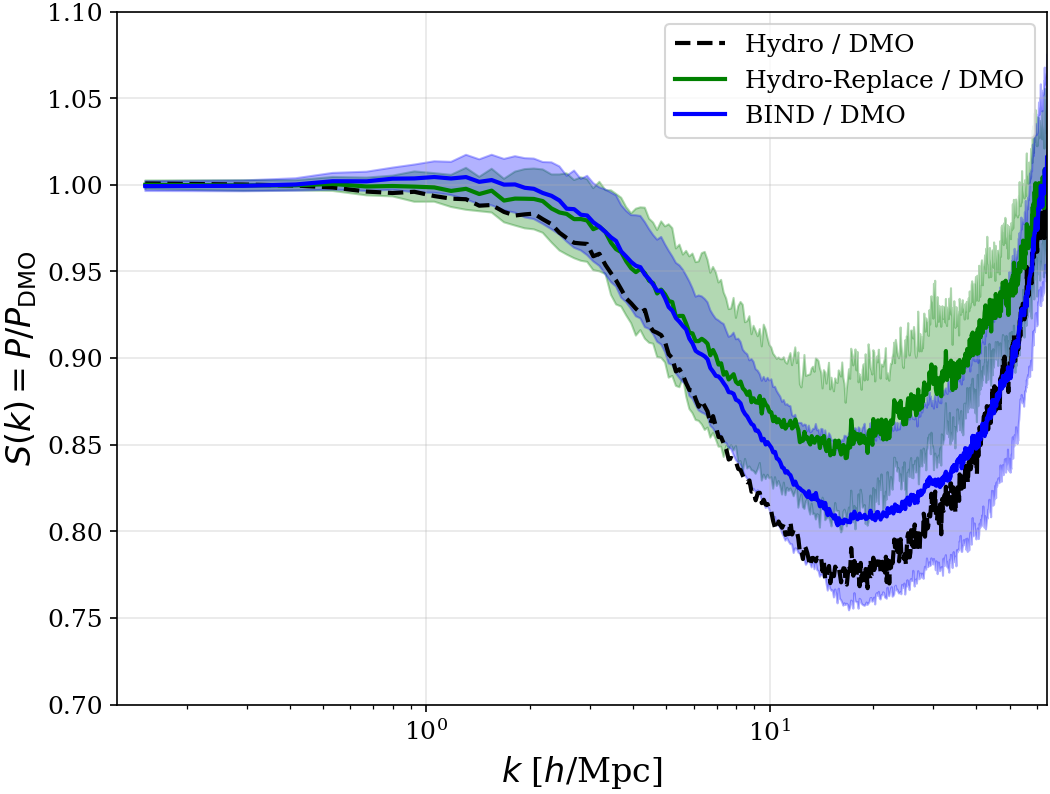

In [4]:
# Figure: CV Power Spectrum Ratio
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Hydro / DMO (target)
ax.semilogx(k, np.mean(cv_hydro_power, axis=0) / np.mean(cv_dm_power, axis=0), 
            label='Hydro / DMO', c='k', ls='--', lw=2)

# Hydro-Replace / DMO
mean_ratio = np.mean(cv_replace_power / cv_dm_power, axis=0)
std_ratio = np.std(cv_replace_power / cv_dm_power, axis=0)
ax.semilogx(k, mean_ratio, label='Hydro-Replace / DMO', c='green', lw=2)
ax.fill_between(k, mean_ratio - std_ratio, mean_ratio + std_ratio, color='green', alpha=0.3)

# BIND / DMO
mean_ratio = np.mean(cv_binded_power / cv_dm_power[:, None, :], axis=(0, 1))
std_ratio = np.std(cv_binded_power / cv_dm_power[:, None, :], axis=(0, 1))
ax.semilogx(k, mean_ratio, label='BIND / DMO', c='blue', lw=2)
ax.fill_between(k, mean_ratio - std_ratio, mean_ratio + std_ratio, color='blue', alpha=0.3)

# Formatting
ax.set_ylim(0.7, 1.1)
ax.set_xlim(2*np.pi/BOX_SIZE, GRID_SIZE*np.pi/BOX_SIZE)
ax.set_xlabel(r'$k$ [$h$/Mpc]', fontsize=16)
ax.set_ylabel(r'$S(k) = P/P_{\rm DMO}$', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

savefig_paper(fig, 'power_spectrum_ratio_CV_fourier_features.pdf')
plt.show()

## 4. 1P Dataset Analysis

Analyze power spectra across one-parameter variation simulations.

In [5]:
# Load 1P parameter information
oneP_params, names_1p, param_array_1p, fiducial_params = load_1p_params()

print(f"1P dataset: {len(names_1p)} simulations")
print(f"Parameters: {list(oneP_params.columns[1:-1])}")

1P dataset: 140 simulations
Parameters: ['Omega0', 'sigma8', 'WindEnergyIn1e51erg', 'RadioFeedbackFactor', 'VariableWindVelFactor', 'RadioFeedbackReiorientationFactor', 'OmegaBaryon', 'HubbleParam', 'n_s', 'MaxSfrTimescale', 'FactorForSofterEQS', 'IMFslope', 'SNII_MinMass_Msun', 'ThermalWindFraction', 'VariableWindSpecMomentum', 'WindFreeTravelDensFac', 'MinWindVel', 'WindEnergyReductionFactor', 'WindEnergyReductionMetallicity', 'WindEnergyReductionExponent', 'WindDumpFactor', 'SeedBlackHoleMass', 'BlackHoleAccretionFactor', 'BlackHoleEddingtonFactor', 'BlackHoleFeedbackFactor', 'BlackHoleRadiativeEfficiency', 'QuasarThreshold', 'QuasarThresholdPower', 'UVBH0beta', 'UVBH0Deltaz', 'UVBHepbeta', 'UVBHepDeltaz', 'SNIa_Rate_Norm', 'SNIa_Rate_DTD_power', 'SofteningComovingType01']


In [ ]:
# Load power spectra for all 1P simulations
oneP_hydro_power = []
oneP_dm_power = []
oneP_replace_power = []
oneP_binded_power = []

for sim_name in names_1p:
    try:
        basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/1P/sim_{sim_name}/'
        
        # Load projected images
        proj = np.load(f'/mnt/home/mlee1/ceph/train_data_1024/projected_images_1P/projections_xy_{sim_name}.npz')
        full_hydro = proj['hydro_dm'] + proj['gas'] + proj['star']
        full_dm = np.load(basepath + '/snap_90/sim_grid.npy')
        hydro_replace = np.load(f'/mnt/home/mlee1/ceph/BIND2d/hydro_replace/1P/{sim_name}/hydro_replace/final_map_hydro_replace.npy')
        BINDED = [np.load(basepath + f'/snap_90/mass_threshold_13/{MODEL_NAME}/ue_1/final_map_{i}.npy') 
                  for i in range(10)]
        
        k, Pk_hydro, Pk_dmo, Pk_replace, _ = compute_power(full_hydro, full_dm, hydro_replace)
        _, Pk_binded, _ = compute_binded_power(BINDED)
        
        oneP_hydro_power.append(Pk_hydro)
        oneP_dm_power.append(Pk_dmo)
        oneP_replace_power.append(Pk_replace)
        oneP_binded_power.append(Pk_binded)
        
    except Exception as e:
        print(f"Error processing 1P sim {sim_name}: {e}")

oneP_dm_power = np.array(oneP_dm_power)
oneP_hydro_power = np.array(oneP_hydro_power)
oneP_replace_power = np.array(oneP_replace_power)
oneP_binded_power = np.array(oneP_binded_power)

print(f"Loaded {len(oneP_dm_power)} 1P simulations")


Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of t

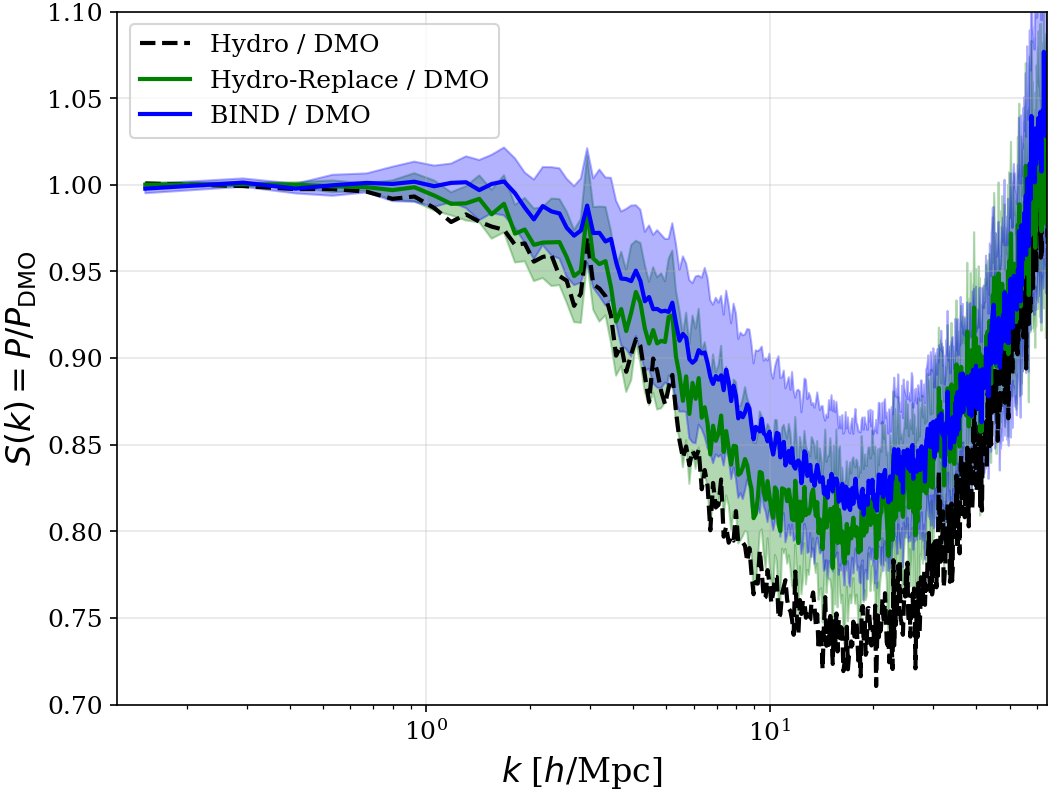

In [7]:
# Figure: 1P Power Spectrum Ratio
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.semilogx(k, np.mean(oneP_hydro_power, axis=0) / np.mean(oneP_dm_power, axis=0), 
            label='Hydro / DMO', c='k', ls='--', lw=2)

mean_ratio = np.mean(oneP_replace_power / oneP_dm_power, axis=0)
std_ratio = np.std(oneP_replace_power / oneP_dm_power, axis=0)
ax.semilogx(k, mean_ratio, label='Hydro-Replace / DMO', c='green', lw=2)
ax.fill_between(k, mean_ratio - std_ratio, mean_ratio + std_ratio, color='green', alpha=0.3)

mean_ratio = np.mean(oneP_binded_power / oneP_dm_power[:, None, :], axis=(0, 1))
std_ratio = np.std(oneP_binded_power / oneP_dm_power[:, None, :], axis=(0, 1))
ax.semilogx(k, mean_ratio, label='BIND / DMO', c='blue', lw=2)
ax.fill_between(k, mean_ratio - std_ratio, mean_ratio + std_ratio, color='blue', alpha=0.3)

ax.set_ylim(0.7, 1.1)
ax.set_xlim(2*np.pi/BOX_SIZE, GRID_SIZE*np.pi/BOX_SIZE)
ax.set_xlabel(r'$k$ [$h$/Mpc]', fontsize=16)
ax.set_ylabel(r'$S(k) = P/P_{\rm DMO}$', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

savefig_paper(fig, 'power_spectrum_ratio_1P_fourier_features.pdf')
plt.show()

### 4.1 1P Parameter Correlation Analysis

Compute Spearman rank correlations between the varied parameter values and power spectrum at each $k$-mode for the 1P dataset.

In [16]:
# Get parameter names from 1P dataset
oneP_param_names = list(oneP_params.columns[1:-1])  # Exclude first (sim name) and last columns
n_1p_params = len(oneP_param_names)

# Build parameter array for loaded simulations
oneP_param_vals = []
for sim_name in names_1p:
    try:
        row = oneP_params[oneP_params.iloc[:, 0] == sim_name].iloc[0, 1:-1].values
        oneP_param_vals.append(row)
    except:
        pass

oneP_param_vals = np.array(oneP_param_vals, dtype=float)

# Compute correlations: BIND power vs parameters for 1P
bind_power_correlations_1p = np.zeros((n_1p_params, len(k)))

for param_idx in range(n_1p_params):
    param_values = oneP_param_vals[:, param_idx]
    
    for k_idx in range(len(k)):
        # Mean BIND power over realizations at this k
        mean_powers = np.nanmean(oneP_binded_power[:, :, k_idx], axis=1)
        
        # Remove NaN values
        valid_mask = ~np.isnan(param_values) & ~np.isnan(mean_powers)
        if np.sum(valid_mask) > 3:
            corr, _ = spearmanr(param_values[valid_mask], mean_powers[valid_mask])
            bind_power_correlations_1p[param_idx, k_idx] = corr

# Compute correlations: Hydro-Replace power vs parameters for 1P
replace_power_correlations_1p = np.zeros((n_1p_params, len(k)))

for param_idx in range(n_1p_params):
    param_values = oneP_param_vals[:, param_idx]
    
    for k_idx in range(len(k)):
        powers = oneP_replace_power[:, k_idx]
        
        valid_mask = ~np.isnan(param_values) & ~np.isnan(powers)
        if np.sum(valid_mask) > 3:
            corr, _ = spearmanr(param_values[valid_mask], powers[valid_mask])
            replace_power_correlations_1p[param_idx, k_idx] = corr

print(f"1P Parameters: {oneP_param_names}")
print(f"Computed correlation matrices: {bind_power_correlations_1p.shape}")

ValueError: operands could not be broadcast together with shapes (140,) (86,) 

NameError: name 'replace_power_correlations_1p' is not defined

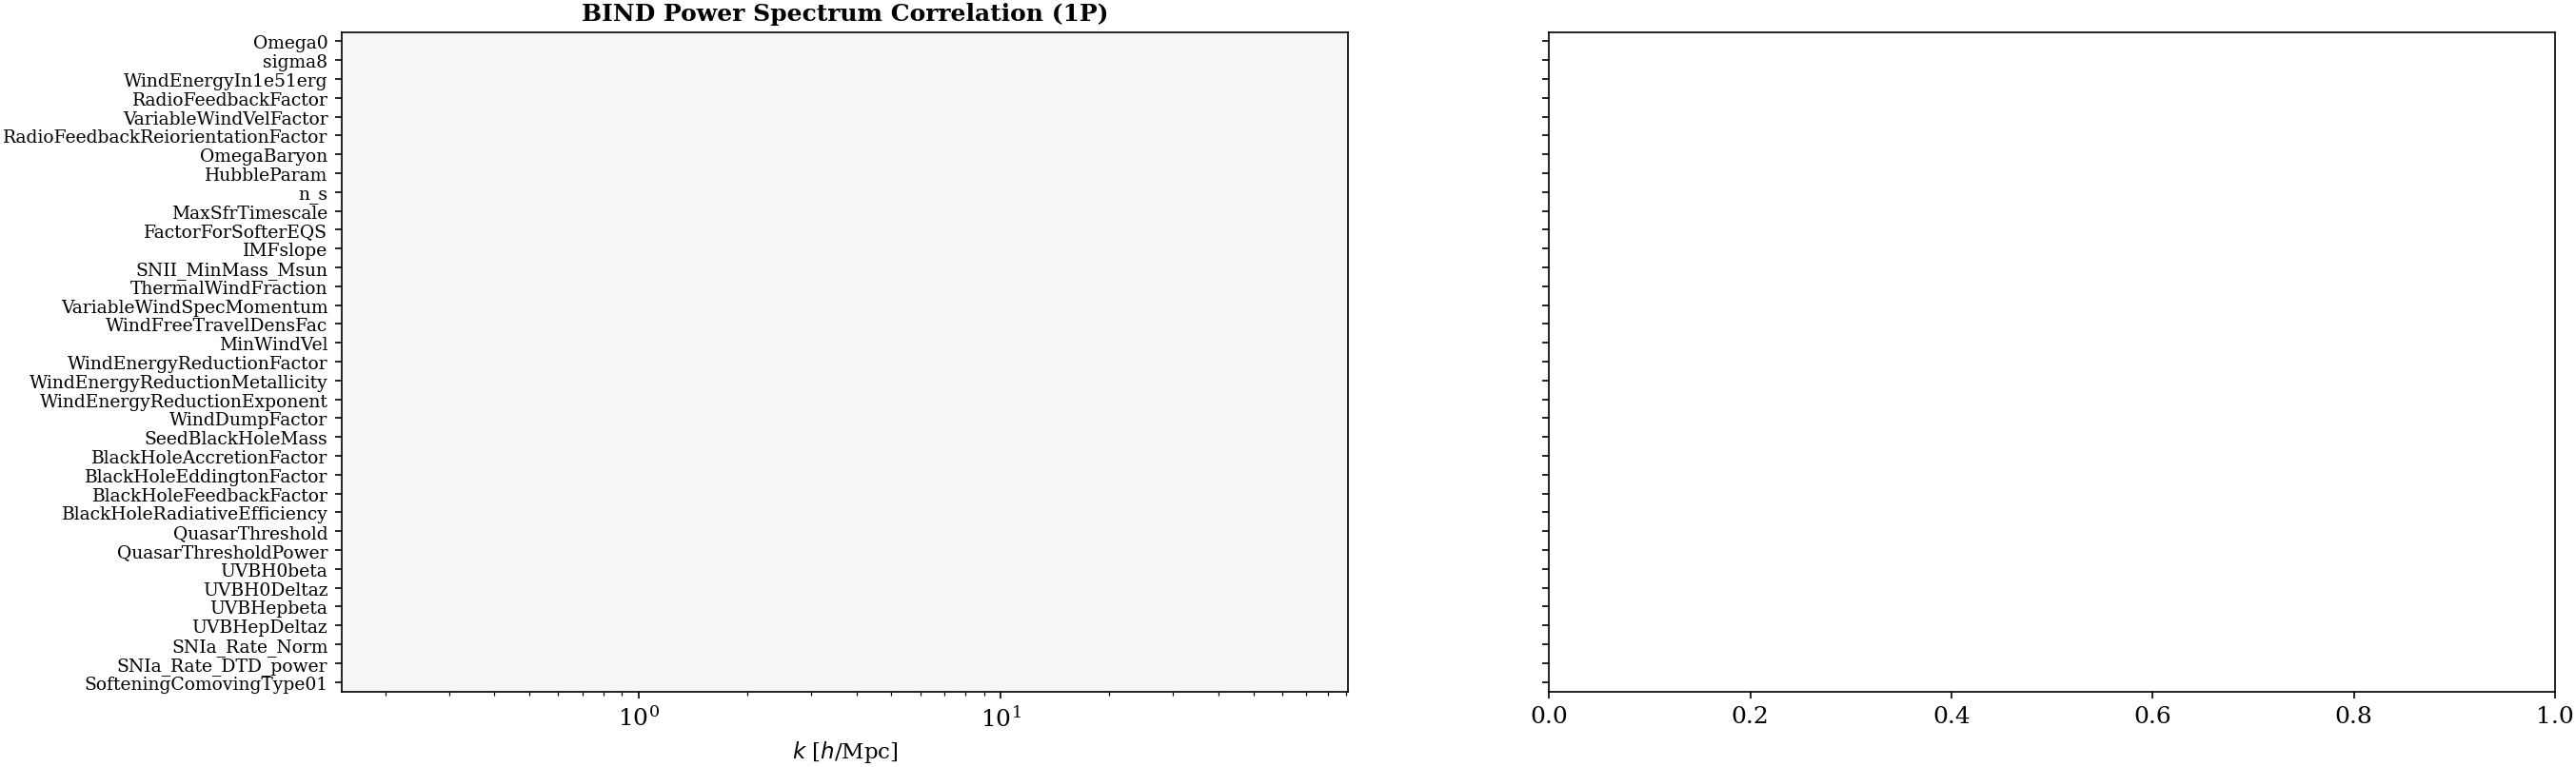

In [17]:
# Figure: Side-by-side correlation heatmaps for 1P dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# BIND correlations
im1 = ax1.imshow(bind_power_correlations_1p, aspect='auto', cmap='RdBu_r', 
                 vmin=-1, vmax=1, origin='upper', extent=[k[0], k[-1], n_1p_params - 0.5, -0.5])
ax1.set_yticks(range(n_1p_params))
ax1.set_yticklabels(oneP_param_names, fontsize=9)
ax1.set_xscale('log')
ax1.set_xlabel(r'$k$ [$h$/Mpc]', fontsize=11)
ax1.set_title('BIND Power Spectrum Correlation (1P)', fontsize=12, fontweight='bold')

# Hydro-Replace correlations
im2 = ax2.imshow(replace_power_correlations_1p, aspect='auto', cmap='RdBu_r', 
                 vmin=-1, vmax=1, origin='upper', extent=[k[0], k[-1], n_1p_params - 0.5, -0.5])
ax2.set_xscale('log')
ax2.set_xlabel(r'$k$ [$h$/Mpc]', fontsize=11)
ax2.set_title('Hydro-Replace Power Spectrum Correlation (1P)', fontsize=12, fontweight='bold')

# Add grid lines
for ax in [ax1, ax2]:
    for i in range(n_1p_params + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.3, alpha=0.3)

# Colorbar
cbar = plt.colorbar(im2, ax=[ax1, ax2], fraction=0.046, pad=0.04)
cbar.set_label(r'Spearman Correlation ($\rho$)', fontsize=11)

plt.tight_layout()
savefig_paper(fig, 'power_spectrum_param_correlation_sidebyside_1P.pdf')
plt.show()

## 5. SB35 Dataset Analysis

Analyze power spectra across the Sobol sequence (35-parameter) simulations.

In [8]:
# Load SB35 metadata
sb35_metadata, sb35_minmax, sb35_sim_nums = load_sb35_metadata()

print(f"SB35 dataset: {len(sb35_sim_nums)} simulations")
print(f"Parameters: {sb35_minmax['ParamName'].tolist()[:5]}... (35 total)")

SB35 dataset: 58 simulations
Parameters: ['Omega0', 'sigma8', 'WindEnergyIn1e51erg', 'RadioFeedbackFactor', 'VariableWindVelFactor']... (35 total)


In [ ]:
# Load power spectra for all SB35 simulations
sb35_hydro_power = []
sb35_dm_power = []
sb35_replace_power = []
sb35_binded_power = []
sb35_param_vals = []

for sim_num in sb35_sim_nums:
    try:
        basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/SB35/sim_{sim_num}/'
        
        proj = np.load(f'/mnt/home/mlee1/ceph/train_data_1024/projected_images/projections_xy_{sim_num}.npz')
        full_hydro = proj['hydro_dm'] + proj['gas'] + proj['star']
        full_dm = np.load(basepath + '/snap_90/sim_grid.npy')
        hydro_replace = np.load(f'/mnt/home/mlee1/ceph/BIND2d/hydro_replace/SB35/sim_{sim_num}/hydro_replace/final_map_hydro_replace.npy')
        BINDED = [np.load(basepath + f'/snap_90/mass_threshold_13/{MODEL_NAME}/ue_1/final_map_{i}.npy') 
                  for i in range(10)]
        
        k, Pk_hydro, Pk_dmo, Pk_replace, _ = compute_power(full_hydro, full_dm, hydro_replace)
        _, Pk_binded, _ = compute_binded_power(BINDED)
        
        sb35_hydro_power.append(Pk_hydro)
        sb35_dm_power.append(Pk_dmo)
        sb35_replace_power.append(Pk_replace)
        sb35_binded_power.append(Pk_binded)
        sb35_param_vals.append(sb35_metadata.loc[sim_num].to_list())
        
    except Exception as e:
        print(f"Error processing SB35 sim {sim_num}: {e}")

sb35_dm_power = np.array(sb35_dm_power)
sb35_hydro_power = np.array(sb35_hydro_power)
sb35_replace_power = np.array(sb35_replace_power)
sb35_binded_power = np.array(sb35_binded_power)
sb35_param_vals = np.array(sb35_param_vals)

print(f"Loaded {len(sb35_dm_power)} SB35 simulations")


Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of t

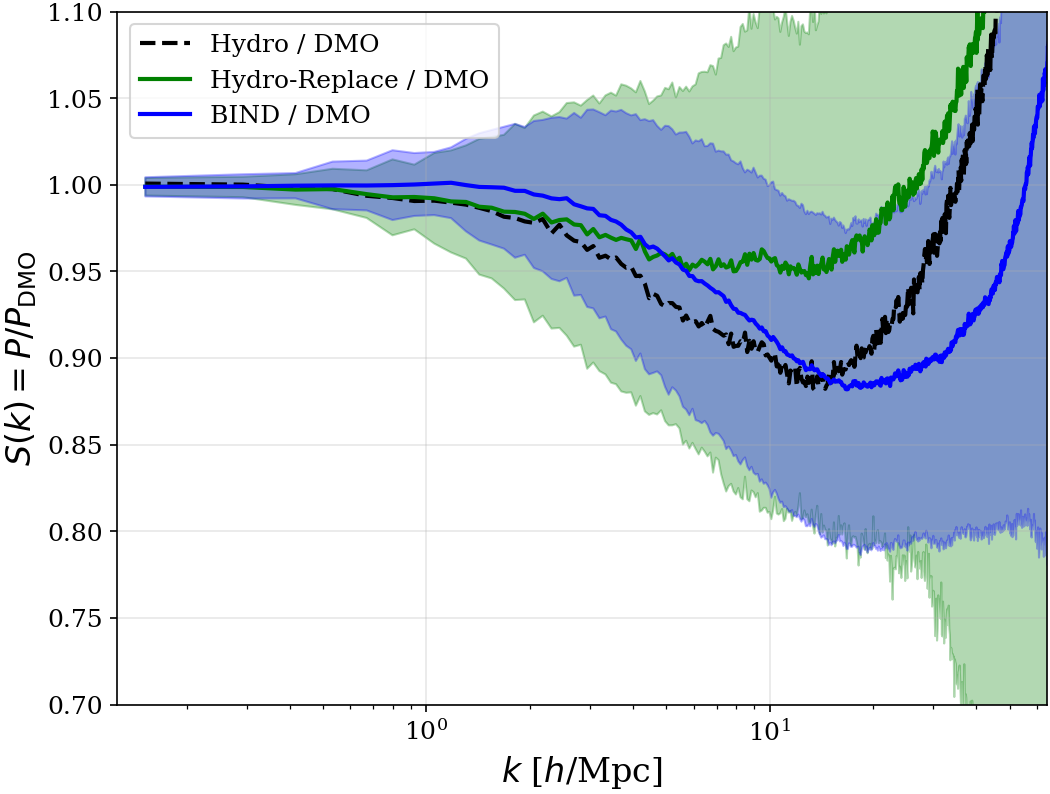

In [11]:
# Figure: SB35 Power Spectrum Ratio
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.semilogx(k, np.mean(sb35_hydro_power, axis=0) / np.mean(sb35_dm_power, axis=0), 
            label='Hydro / DMO', c='k', ls='--', lw=2)

mean_ratio = np.mean(sb35_replace_power / sb35_dm_power, axis=0)
std_ratio = np.std(sb35_replace_power / sb35_dm_power, axis=0)
ax.semilogx(k, mean_ratio, label='Hydro-Replace / DMO', c='green', lw=2)
ax.fill_between(k, mean_ratio - std_ratio, mean_ratio + std_ratio, color='green', alpha=0.3)

mean_ratio = np.mean(sb35_binded_power / sb35_dm_power[:, None, :], axis=(0, 1))
std_ratio = np.std(sb35_binded_power / sb35_dm_power[:, None, :], axis=(0, 1))
ax.semilogx(k, mean_ratio, label='BIND / DMO', c='blue', lw=2)
ax.fill_between(k, mean_ratio - std_ratio, mean_ratio + std_ratio, color='blue', alpha=0.3)

ax.set_ylim(0.7, 1.1)
ax.set_xlim(2*np.pi/BOX_SIZE, GRID_SIZE*np.pi/BOX_SIZE)
ax.set_xlabel(r'$k$ [$h$/Mpc]', fontsize=16)
ax.set_ylabel(r'$S(k) = P/P_{\rm DMO}$', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

savefig_paper(fig, 'power_spectrum_ratio_SB35_noparam_pred.pdf')
plt.show()

## 6. Parameter Correlation Analysis

Investigate how power spectrum correlates with cosmological/astrophysical parameters.

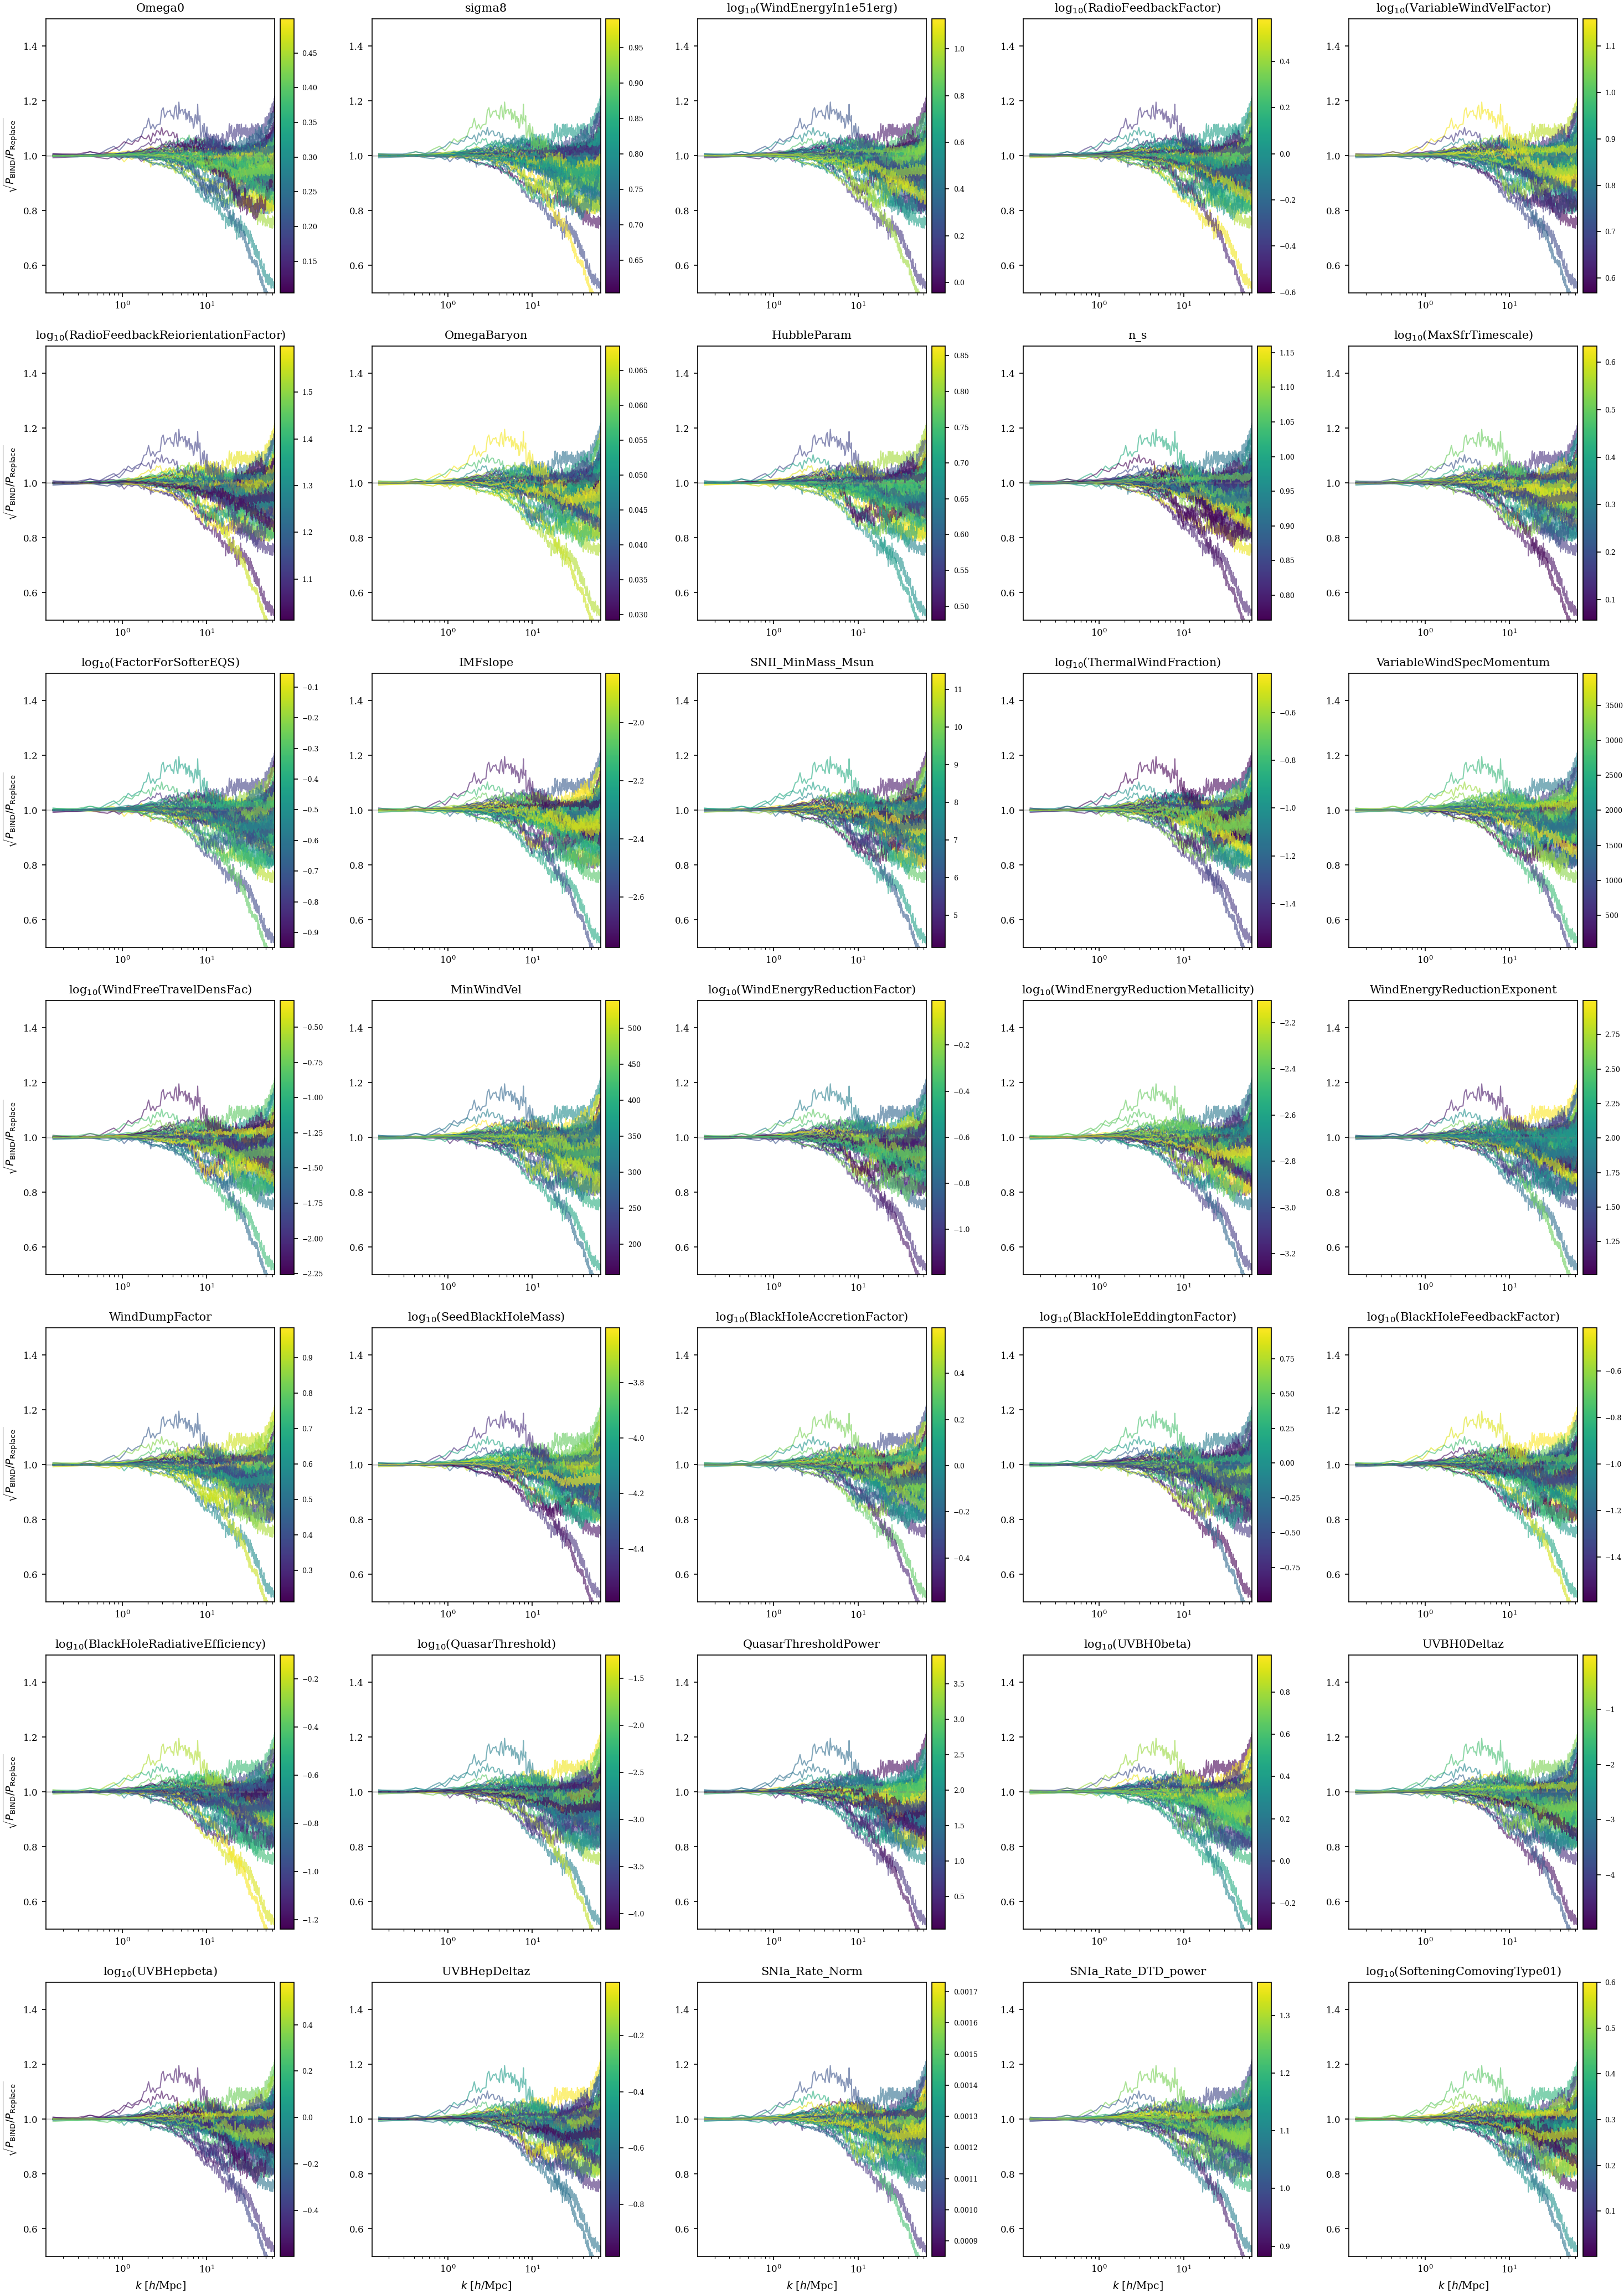

In [12]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Figure: Power spectrum ratio colored by each parameter
fig, axes = plt.subplots(7, 5, figsize=(20, 28))
axes = axes.flatten()

for param_idx in range(35):
    ax = axes[param_idx]
    
    param_name = sb35_minmax.loc[param_idx, 'ParamName']
    log_flag = sb35_minmax.loc[param_idx, 'LogFlag']
    param_values = sb35_param_vals[:, param_idx]
    
    # Apply log transformation if needed
    if log_flag:
        param_values_color = np.log10(param_values)
        color_label = f'log$_{{10}}$({param_name})'
    else:
        param_values_color = param_values
        color_label = param_name
    
    # Setup colormap
    norm = Normalize(vmin=param_values_color.min(), vmax=param_values_color.max())
    cmap = cm.viridis
    
    # Plot each simulation
    for i in range(len(sb35_replace_power)):
        ratio = np.mean([np.sqrt(sb35_binded_power[i, j] / sb35_replace_power[i]) 
                        for j in range(10)], axis=0)
        color = cmap(norm(param_values_color[i]))
        ax.semilogx(k, ratio, color=color, alpha=0.6, linewidth=1)
    
    # Formatting
    ax.set_xlim(2*np.pi/BOX_SIZE, GRID_SIZE*np.pi/BOX_SIZE)
    ax.set_ylim(0.5, 1.5)
    ax.axhline(1.0, c='gray', ls='--', alpha=0.3)
    ax.set_title(color_label, fontsize=10)
    ax.tick_params(labelsize=8)
    
    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=ax, pad=0.02)
    cbar.ax.tick_params(labelsize=6)
    
    if param_idx % 5 == 0:
        ax.set_ylabel(r'$\sqrt{P_{\rm BIND}/P_{\rm Replace}}$', fontsize=9)
    if param_idx >= 30:
        ax.set_xlabel(r'$k$ [$h$/Mpc]', fontsize=9)

plt.tight_layout()
savefig_paper(fig, 'power_spectrum_ratio_by_param_SB35.pdf')
plt.show()

### 6.1 Spearman Correlation Heatmaps

Compute Spearman rank correlations between parameter values and power spectrum at each $k$-mode.

In [15]:
# Compute correlations: BIND power vs parameters
bind_power_correlations = np.zeros((35, len(k)))

for param_idx in range(35):
    param_values = sb35_param_vals[:, param_idx]
    
    for k_idx in range(len(k)):
        # Mean BIND power over realizations at this k
        mean_powers = np.nanmean(sb35_binded_power[:, :, k_idx], axis=1)
        
        if len(mean_powers) > 3:
            corr, _ = spearmanr(param_values, mean_powers)
            bind_power_correlations[param_idx, k_idx] = corr

# Compute correlations: Hydro-Replace power vs parameters
replace_power_correlations = np.zeros((35, len(k)))

for param_idx in range(35):
    param_values = sb35_param_vals[:, param_idx]
    
    for k_idx in range(len(k)):
        powers = sb35_replace_power[:, k_idx]
        
        if len(powers) > 3:
            corr, _ = spearmanr(param_values, powers)
            replace_power_correlations[param_idx, k_idx] = corr

print(f"Computed correlation matrices: {bind_power_correlations.shape}")

Computed correlation matrices: (35, 724)


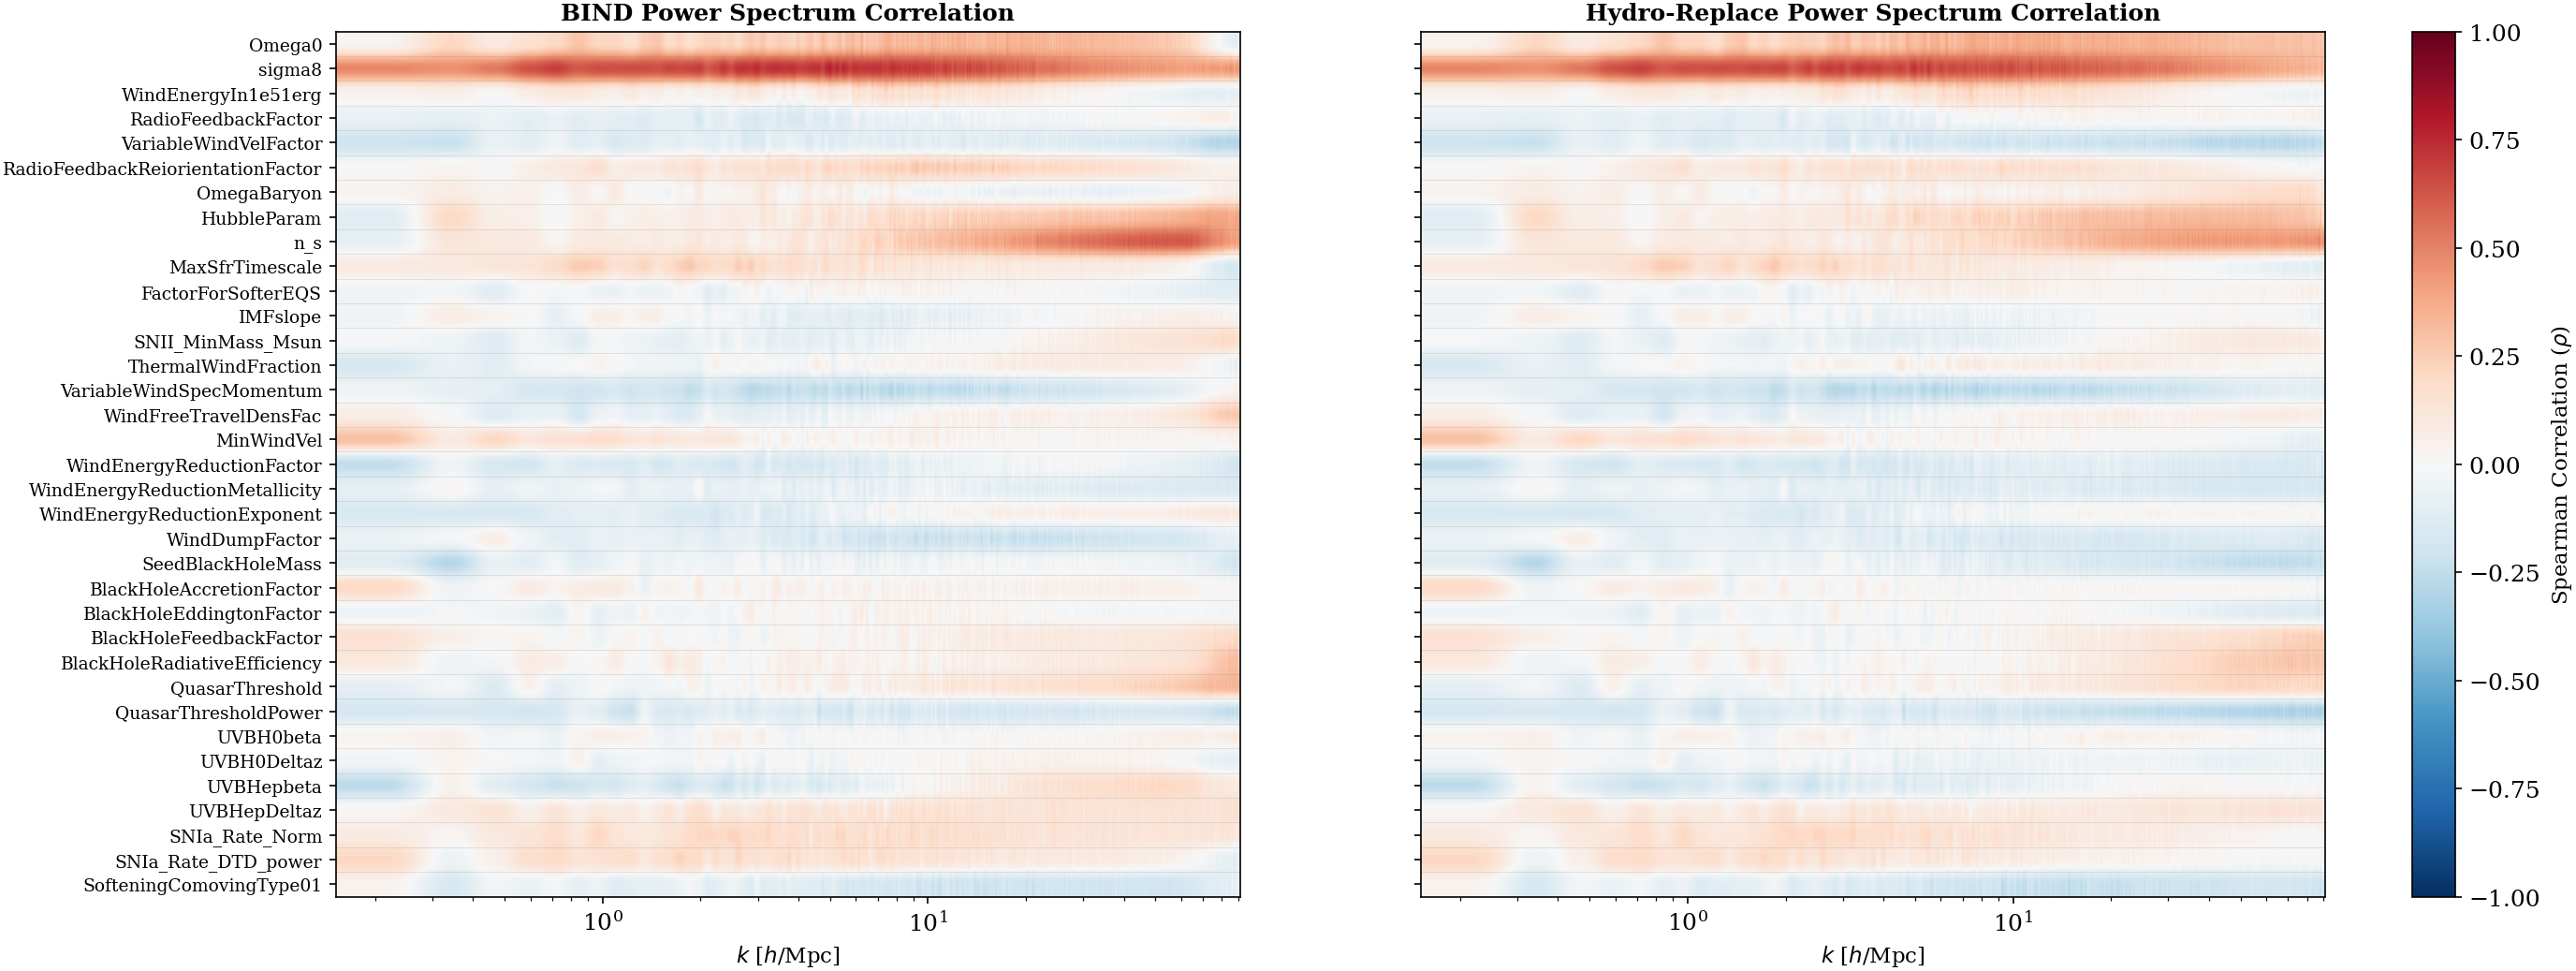

In [14]:
# Figure: Side-by-side correlation heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

param_names = [sb35_minmax.loc[i, 'ParamName'] for i in range(35)]

# BIND correlations
im1 = ax1.imshow(bind_power_correlations, aspect='auto', cmap='RdBu_r', 
                 vmin=-1, vmax=1, origin='upper', extent=[k[0], k[-1], 34.5, -0.5])
ax1.set_yticks(range(35))
ax1.set_yticklabels(param_names, fontsize=9)
ax1.set_xscale('log')
ax1.set_xlabel(r'$k$ [$h$/Mpc]', fontsize=11)
ax1.set_title('BIND Power Spectrum Correlation', fontsize=12, fontweight='bold')

# Hydro-Replace correlations
im2 = ax2.imshow(replace_power_correlations, aspect='auto', cmap='RdBu_r', 
                 vmin=-1, vmax=1, origin='upper', extent=[k[0], k[-1], 34.5, -0.5])
ax2.set_xscale('log')
ax2.set_xlabel(r'$k$ [$h$/Mpc]', fontsize=11)
ax2.set_title('Hydro-Replace Power Spectrum Correlation', fontsize=12, fontweight='bold')

# Add grid lines
for ax in [ax1, ax2]:
    for i in range(36):
        ax.axhline(i - 0.5, color='gray', linewidth=0.3, alpha=0.3)

# Colorbar
cbar = plt.colorbar(im2, ax=[ax1, ax2], fraction=0.046, pad=0.04)
cbar.set_label(r'Spearman Correlation ($\rho$)', fontsize=11)

savefig_paper(fig, 'power_spectrum_param_correlation_sidebyside.pdf')
plt.show()

---

## Summary

This notebook analyzed matter power spectra across three datasets:

1. **CV (Cosmic Variance)**: 24 simulations with fixed parameters but different initial conditions
2. **1P (One-Parameter)**: Simulations varying one parameter at a time
3. **SB35 (Sobol-35)**: Simulations spanning 35-dimensional parameter space

**Key findings:**
- BIND reproduces the power spectrum suppression $S(k)$ better than hydro-replacement
- Correlations with cosmological parameters are similar between BIND and hydro-replace
- Largest variations occur at small scales (high $k$) where baryonic effects dominate

**Next:** See `03_density_profile_analysis.ipynb` for radial profile analysis.